In [1]:
"""
Train a diffusion model for recommendation
"""

import argparse
from ast import parse
import os
import time
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from models.Autoencoder import AutoEncoder as AE
from models.Autoencoder import compute_loss

import models.gaussian_diffusion as gd
from models.DNN import DNN
import evaluate_utils
import data_utils
from copy import deepcopy

import random
random_seed = 1
torch.manual_seed(random_seed) # cpu
torch.cuda.manual_seed(random_seed) # gpu
np.random.seed(random_seed) # numpy
random.seed(random_seed) # random and transforms
torch.backends.cudnn.deterministic=True # cudnn
def worker_init_fn(worker_id):
    np.random.seed(random_seed + worker_id)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='ml-1m_clean', help='choose the dataset')
parser.add_argument('--data_path', type=str, default='../datasets/ml-1m_clean/', help='load data path')
parser.add_argument('--emb_path', type=str, default='../datasets/')
parser.add_argument('--lr1', type=float, default=0.001, help='learning rate for Autoencoder')
parser.add_argument('--lr2', type=float, default=0.0005, help='learning rate for MLP')
parser.add_argument('--wd1', type=float, default=0.0, help='weight decay for Autoencoder')
parser.add_argument('--wd2', type=float, default=0.0, help='weight decay for MLP')
parser.add_argument('--batch_size', type=int, default=400)
parser.add_argument('--epochs', type=int, default=1000, help='upper epoch limit')
parser.add_argument('--topN', type=str, default='[10, 20, 50, 100]')
parser.add_argument('--tst_w_val', action='store_true', help='test with validation')
parser.add_argument('--cuda', action='store_true', help='use CUDA')
parser.add_argument('--gpu', type=str, default='0', help='gpu card ID')
parser.add_argument('--save_path', type=str, default='./saved_models/', help='save model path')
parser.add_argument('--log_name', type=str, default='log', help='the log name')
parser.add_argument('--round', type=int, default=1, help='record the experiment')

# parser.add_argument('--dataset', type=str, default='ml-1m_clean', help='choose the dataset')
# parser.add_argument('--data_path', type=str, default='../datasets/ml-1m_clean/', help='load data path')
# parser.add_argument('--emb_path', type=str, default='../datasets/')
# parser.add_argument('--lr', type=float, default=5e-5, help='learning rate')
# parser.add_argument('--weight_decay', type=float, default=0.0)
# parser.add_argument('--batch_size', type=int, default=400)
# parser.add_argument('--epochs', type=int, default=1000, help='upper epoch limit')
# parser.add_argument('--topN', type=str, default='[10, 20, 50, 100]')
# parser.add_argument('--tst_w_val', action='store_true', help='test with validation')
# parser.add_argument('--cuda', action='store_true', help='use CUDA')
# parser.add_argument('--gpu', type=str, default='0', help='gpu card ID')
# parser.add_argument('--save_path', type=str, default='./saved_models/', help='save model path')
# parser.add_argument('--log_name', type=str, default='log', help='the log name')
# parser.add_argument('--round', type=int, default=1, help='record the experiment')

# # params for the model
# parser.add_argument('--time_type', type=str, default='cat', help='cat or add')
# parser.add_argument('--dims', type=str, default='[1000]', help='the dims for the DNN')
# parser.add_argument('--norm', type=bool, default=False, help='Normalize the input or not')
# parser.add_argument('--emb_size', type=int, default=10, help='timestep embedding size')

# params for diffusion
parser.add_argument('--mean_type', type=str, default='x0', help='MeanType for diffusion: x0, eps')
parser.add_argument('--steps', type=int, default=40, help='diffusion steps')
parser.add_argument('--noise_schedule', type=str, default='linear-var', help='the schedule for noise generating')
parser.add_argument('--noise_scale', type=float, default=0.005, help='noise scale for noise generating')
parser.add_argument('--noise_min', type=float, default=0.005, help='noise lower bound for noise generating')
parser.add_argument('--noise_max', type=float, default=0.02, help='noise upper bound for noise generating')
parser.add_argument('--sampling_noise', type=bool, default=False, help='sampling with noise or not')
parser.add_argument('--sampling_steps', type=int, default=40, help='steps of the forward process during inference')
parser.add_argument('--reweight', type=bool, default=False, help='assign different weight to different timestep or not')

# params for the Autoencoder
parser.add_argument('--n_cate', type=int, default=2, help='category num of items')
parser.add_argument('--in_dims', type=str, default='[300]', help='the dims for the encoder')
parser.add_argument('--out_dims', type=str, default='[]', help='the hidden dims for the decoder')
parser.add_argument('--act_func', type=str, default='tanh', help='activation function for autoencoder')
parser.add_argument('--lamda', type=float, default=0.03, help='hyper-parameter of multinomial log-likelihood for AE: 0.01, 0.02, 0.03, 0.05')
parser.add_argument('--optimizer1', type=str, default='AdamW', help='optimizer for AE: Adam, AdamW, SGD, Adagrad, Momentum')
parser.add_argument('--anneal_cap', type=float, default=0.005)
parser.add_argument('--anneal_steps', type=int, default=500)
parser.add_argument('--vae_anneal_cap', type=float, default=0.3)
parser.add_argument('--vae_anneal_steps', type=int, default=200)
parser.add_argument('--reparam', type=bool, default=True, help="Autoencoder with variational inference or not")

# params for the MLP
parser.add_argument('--time_type', type=str, default='cat', help='cat or add')
parser.add_argument('--mlp_dims', type=str, default='[300]', help='the dims for the DNN')
parser.add_argument('--norm', type=bool, default=False, help='Normalize the input or not')
parser.add_argument('--emb_size', type=int, default=10, help='timestep embedding size')
parser.add_argument('--mlp_act_func', type=str, default='tanh', help='the activation function for MLP')
parser.add_argument('--optimizer2', type=str, default='AdamW', help='optimizer for MLP: Adam, AdamW, SGD, Adagrad, Momentum')


args = parser.parse_args(args=[])
print("args:", args)

args: Namespace(act_func='tanh', anneal_cap=0.005, anneal_steps=500, batch_size=400, cuda=False, data_path='../datasets/ml-1m_clean/', dataset='ml-1m_clean', emb_path='../datasets/', emb_size=10, epochs=1000, gpu='0', in_dims='[300]', lamda=0.03, log_name='log', lr1=0.001, lr2=0.0005, mean_type='x0', mlp_act_func='tanh', mlp_dims='[300]', n_cate=2, noise_max=0.02, noise_min=0.005, noise_scale=0.005, noise_schedule='linear-var', norm=False, optimizer1='AdamW', optimizer2='AdamW', out_dims='[]', reparam=True, reweight=False, round=1, sampling_noise=False, sampling_steps=40, save_path='./saved_models/', steps=40, time_type='cat', topN='[10, 20, 50, 100]', tst_w_val=False, vae_anneal_cap=0.3, vae_anneal_steps=200, wd1=0.0, wd2=0.0)


In [2]:
args.steps = 40
args.noise_scale = 0.005
args.noise_min = 0.005
args.noise_max = 0.02


In [3]:
### args.steps을 classify하는 discriminative model이 필요
### gaussian diffusion의 1. sample_timesteps(self, batch_size, device, method='uniform', uniform_prob=0.001) 2. q_sample(self, x_start, t, noise=None) 함수를 사용
### dataloader for batch_idx, batch in enumerate(train_loader):

args.cuda = True
args.gpu = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu

device = torch.device("cuda" if args.cuda else "cpu")
print('device: ', device)

print("Starting time: ", time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))

### DATA LOAD ###
train_path = args.data_path + 'train_list.npy'
valid_path = args.data_path + 'valid_list.npy'
test_path = args.data_path + 'test_list.npy'

train_data, valid_y_data, test_y_data, n_user, n_item = data_utils.data_load(train_path, valid_path, test_path)
train_dataset = data_utils.DataDiffusion(torch.FloatTensor(train_data.A))
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=True, num_workers=4, worker_init_fn=worker_init_fn)
test_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)

if args.tst_w_val:
    tv_dataset = data_utils.DataDiffusion(torch.FloatTensor(train_data.A) + torch.FloatTensor(valid_y_data.A))
    test_twv_loader = DataLoader(tv_dataset, batch_size=args.batch_size, shuffle=False)
mask_tv = train_data + valid_y_data

print('data ready.')

### Build Autoencoder ###
emb_path = args.emb_path + args.dataset + '/item_emb.npy'
item_emb = torch.from_numpy(np.load(emb_path, allow_pickle=True))
assert len(item_emb) == n_item
out_dims = eval(args.out_dims)
in_dims = eval(args.in_dims)[::-1]
Autoencoder = AE(item_emb, args.n_cate, in_dims, out_dims, device, args.act_func, args.reparam).to(device)


### Build Gaussian Diffusion ###
if args.mean_type == 'x0':
    mean_type = gd.ModelMeanType.START_X
elif args.mean_type == 'eps':
    mean_type = gd.ModelMeanType.EPSILON
else:
    raise ValueError("Unimplemented mean type %s" % args.mean_type)

diffusion = gd.GaussianDiffusion(mean_type, args.noise_schedule, \
        args.noise_scale, args.noise_min, args.noise_max, args.steps, device).to(device)

# ### Build MLP ###
### Build MLP ###
latent_size = in_dims[-1]
mlp_out_dims = eval(args.mlp_dims) + [latent_size]
mlp_in_dims = mlp_out_dims[::-1]
model = DNN(mlp_in_dims, mlp_out_dims, args.emb_size, time_type="cat", norm=args.norm, act_func=args.mlp_act_func).to(device)

# optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
# print("models ready.")

# param_num = 0
# mlp_num = sum([param.nelement() for param in model.parameters()])
# diff_num = sum([param.nelement() for param in diffusion.parameters()])  # diffusion에 parameter없음 ==> 0
# param_num = mlp_num + diff_num
# print("Number of all parameters:", param_num)

device:  cuda
Starting time:  2024-12-07 17:55:29
user num: 5949
item num: 2810
data ready.
running k-means on cuda..


[running kmeans]: 9it [00:00, 284.14it/s, center_shift=0.000056, iteration=9, tol=0.000100]

category length:  [1850, 960]
Latent dims of each category:  [[197], [103]]


In [4]:
in_dims

[300]

In [5]:
mlp_in_dims

[300, 300]

In [6]:
print(model)

DNN(
  (emb_layer): Linear(in_features=10, out_features=10, bias=True)
  (in_layers): Sequential(
    (0): Linear(in_features=310, out_features=300, bias=True)
    (1): Tanh()
  )
  (out_layers): Sequential(
    (0): Linear(in_features=300, out_features=300, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


In [8]:
from models.DNN import TCLS

time_classifier = TCLS(mlp_in_dims, args.steps)
time_classifier = time_classifier.to(device)
print(time_classifier)
time_optimizer = optim.Adam(time_classifier.parameters(), lr=0.001)
time_criterion = nn.CrossEntropyLoss()

TCLS(
  (in_layers): ModuleList(
    (0): Linear(in_features=300, out_features=300, bias=True)
  )
  (out_layer): Linear(in_features=300, out_features=40, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)


In [9]:
cls_num = sum([param.nelement() for param in time_classifier.parameters()])
cls_num             

102340

In [10]:
model_path = "./saved_models/"
if args.dataset == "amazon-book_clean":
    model_name = "/amazon-book_clean_0.0005lr1_0.0001lr2_0.0wd1_0.0wd2_bs400_cate2_in[300]_out[]_lam0.05_dims[300]_emb10_x0_steps5_scale0.5_min0.001_max0.005_sample0_reweight1_log.pth"
    AE_name = "/amazon-book_clean_0.0005lr1_0.0001lr2_0.0wd1_0.0wd2_bs400_cate2_in[300]_out[]_lam0.05_dims[300]_emb10_x0_steps5_scale0.5_min0.001_max0.005_sample0_reweight1_log_AE.pth"
elif args.dataset == "yelp_clean":
    model_name = "/yelp_clean_0.0005lr1_0.0001lr2_0.0wd1_0.0wd2_bs400_cate2_in[300]_out[]_lam0.03_dims[300]_emb10_x0_steps5_scale0.01_min0.005_max0.01_sample0_reweight0_log.pth"
    AE_name = "/yelp_clean_0.0005lr1_0.0001lr2_0.0wd1_0.0wd2_bs400_cate2_in[300]_out[]_lam0.03_dims[300]_emb10_x0_steps5_scale0.01_min0.005_max0.01_sample0_reweight0_log_AE.pth"
elif args.dataset == "ml-1m_clean":
    model_name = "/ml-1m_clean_0.001lr1_0.0005lr2_0.0wd1_0.0wd2_bs400_cate2_in[300]_out[]_lam0.03_dims[300]_emb10_x0_steps40_scale0.005_min0.005_max0.02_sample0_reweight1_log.pth"
    AE_name = "/ml-1m_clean_0.001lr1_0.0005lr2_0.0wd1_0.0wd2_bs400_cate2_in[300]_out[]_lam0.03_dims[300]_emb10_x0_steps40_scale0.005_min0.005_max0.02_sample0_reweight1_log_AE.pth"

In [11]:
Autoencoder = torch.load(model_path + args.dataset + AE_name).to(device)
print(Autoencoder)

AutoEncoder(
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1850, out_features=394, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=960, out_features=206, bias=True)
      (1): Tanh()
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=2810, bias=True)
  )
)


In [12]:
from tqdm import tqdm

epochs = 1001
log_interval = 50
save_path = './checkpoints/'

if not os.path.exists(save_path):
    os.makedirs(save_path)

## the version of the classifier network / you have to change the number of the version
version = 2

time_classifier.train()
for epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        time_optimizer.zero_grad()
        batch = batch.to(device)
        batch_cate, batch_latent, vae_kl = Autoencoder.Encode(batch)
        ts, _ = diffusion.sample_timesteps(batch_latent.shape[0], device)
        batch_ts = diffusion.q_sample(batch_latent, ts).to(device)
        logits = time_classifier(batch_ts-batch_latent)
        loss = time_criterion(logits, ts)
        loss.backward()
        time_optimizer.step()

        running_loss += loss.item()

    if epoch % log_interval == 0:
        print(f"Epoch {epoch}, Loss: {running_loss/len(train_loader):.4f}")
        checkpoint_path = f"{save_path}{args.dataset}_time_classifier_epoch_{epoch}_steps{args.steps}_min{args.noise_min}_max{args.noise_max}_latent_ver{version}.pth"
        torch.save(time_classifier.state_dict(), checkpoint_path)

  0%|          | 1/1001 [00:01<23:14,  1.39s/it]

Epoch 0, Loss: 3.6889


  5%|▌         | 51/1001 [00:21<06:53,  2.30it/s]

Epoch 50, Loss: 3.6096


 10%|█         | 101/1001 [00:42<05:52,  2.56it/s]

Epoch 100, Loss: 3.4387


 15%|█▌        | 151/1001 [01:02<05:56,  2.38it/s]

Epoch 150, Loss: 3.2896


 20%|██        | 201/1001 [01:22<05:08,  2.59it/s]

Epoch 200, Loss: 3.1936


 25%|██▌       | 251/1001 [01:44<05:02,  2.48it/s]

Epoch 250, Loss: 3.1284


 30%|███       | 301/1001 [02:04<04:43,  2.47it/s]

Epoch 300, Loss: 3.0644


 35%|███▌      | 351/1001 [02:25<04:20,  2.49it/s]

Epoch 350, Loss: 3.0275


 40%|████      | 401/1001 [02:45<04:09,  2.40it/s]

Epoch 400, Loss: 2.9841


 45%|████▌     | 451/1001 [03:05<03:47,  2.42it/s]

Epoch 450, Loss: 2.9570


 50%|█████     | 501/1001 [03:26<03:31,  2.36it/s]

Epoch 500, Loss: 2.9320


 55%|█████▌    | 551/1001 [03:46<02:49,  2.66it/s]

Epoch 550, Loss: 2.9080


 60%|██████    | 601/1001 [04:06<02:39,  2.50it/s]

Epoch 600, Loss: 2.8938


 65%|██████▌   | 651/1001 [04:27<02:32,  2.30it/s]

Epoch 650, Loss: 2.8780


 70%|███████   | 701/1001 [04:48<02:02,  2.45it/s]

Epoch 700, Loss: 2.8647


 75%|███████▌  | 751/1001 [05:08<01:43,  2.41it/s]

Epoch 750, Loss: 2.8404


 80%|████████  | 801/1001 [05:29<01:20,  2.47it/s]

Epoch 800, Loss: 2.8361


 85%|████████▌ | 851/1001 [05:49<01:04,  2.32it/s]

Epoch 850, Loss: 2.8193


 90%|█████████ | 901/1001 [06:09<00:39,  2.51it/s]

Epoch 900, Loss: 2.8134


 95%|█████████▌| 951/1001 [06:29<00:19,  2.56it/s]

Epoch 950, Loss: 2.8080


100%|██████████| 1001/1001 [06:49<00:00,  2.44it/s]

Epoch 1000, Loss: 2.8058


In [14]:
time_classifier = TCLS(mlp_in_dims, args.steps)
time_classifier.load_state_dict(torch.load('./checkpoints/ml-1m_clean_time_classifier_epoch_1000_steps40_min0.005_max0.02_latent_ver2.pth'))
time_classifier.eval()

TCLS(
  (in_layers): ModuleList(
    (0): Linear(in_features=300, out_features=300, bias=True)
  )
  (out_layer): Linear(in_features=300, out_features=40, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)

In [16]:
mlp_in_dims

[300, 300]

In [10]:
def compute_entropy_batch(logits):
    """
    배치에 대해 엔트로피 값을 계산하는 함수.
    
    Arguments:
    probabilities -- (5000, 1000) 크기의 확률 분포 (Tensor)
    
    Returns:
    entropies -- (5000, 1) 크기의 엔트로피 값들 (Tensor)
    """
    # 엔트로피 계산 (각 이미지마다 엔트로피를 계산)
    probabilities = F.softmax(logits, dim=1)
    entropies = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1, keepdim=True)
    return entropies

In [8]:
### test_loader에서 batch 꺼내서 time classifier의 엔트로피 및 acc@k 분석

def evaluate_accuracy_k(classifier, testloader, k, timestep):
    classifier.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(testloader)):
            batch = batch.to(device)
            ts = torch.full((batch.shape[0],), timestep).to(device)
            batch_ts = diffusion.q_sample(batch, ts).to(device)
            logits = classifier(batch_ts-batch)

            _, topk_preds = torch.topk(logits, k, dim = 1)

            correct += torch.sum(topk_preds.eq(ts.view(-1,1).expand_as(topk_preds))).item()
            total += batch.shape[0]
        accuracy = correct / total *100.
        print(f"Top-{k} Accuracy on the test set at timestep {timestep}: {accuracy:.2f}%")
        return accuracy

273it [00:34,  7.98it/s]


Top-2 Accuracy on the test set at timestep 0: 100.00%


273it [00:32,  8.30it/s]


Top-2 Accuracy on the test set at timestep 1: 100.00%


273it [00:28,  9.74it/s]


Top-2 Accuracy on the test set at timestep 2: 97.09%


273it [00:32,  8.33it/s]


Top-2 Accuracy on the test set at timestep 3: 29.86%


273it [00:31,  8.76it/s]


Top-2 Accuracy on the test set at timestep 4: 10.21%


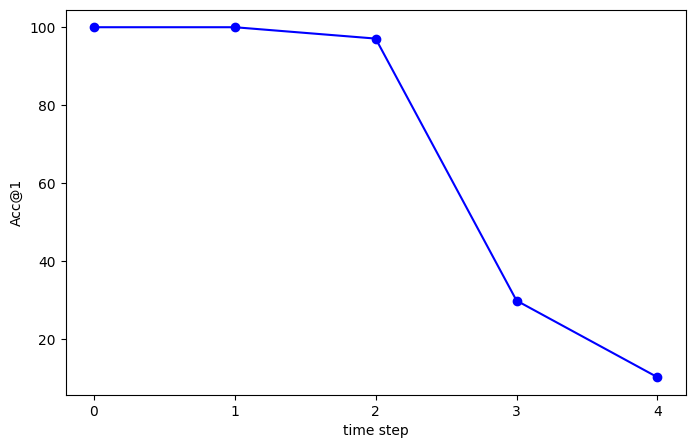

In [15]:
import matplotlib.pyplot as plt

k = 2
acc_k_arr = []
for ts in range(args.steps):
    accuracy = evaluate_accuracy_k(time_classifier, test_loader, k=k, timestep=ts)
    acc_k_arr.append(accuracy)

plt.figure(figsize=(8, 5))
plt.plot(range(args.steps), acc_k_arr, marker='o', linestyle='-', color='b')
plt.xlabel('time step')
plt.ylabel('Acc@1')
plt.xticks(range(args.steps))  # 인덱스 값 표시
plt.show()

In [11]:
def compute_entropy_statistics(classifier, testloader, timestep):
    """
    test_dataloader의 모든 샘플에 대해 엔트로피 평균과 분산을 계산하는 함수.
    
    Arguments:
    classifier -- 확률 분포(logits)를 출력하는 분류기 모델
    test_dataloader -- 테스트 데이터 로더
    
    Returns:
    mean_entropy -- 모든 샘플의 엔트로피 평균
    var_entropy -- 모든 샘플의 엔트로피 분산
    """
    classifier.eval()  # 모델을 평가 모드로 전환
    entropies = []

    with torch.no_grad():
        for batch in testloader:
            batch = batch.to(device)  # GPU 사용 시
            ts = torch.full((batch.shape[0],), timestep).to(device)
            batch_ts = diffusion.q_sample(batch, ts).to(device)
            logits = classifier(batch_ts)
            batch_entropies = compute_entropy_batch(logits)
            entropies.append(batch_entropies)

    # 모든 배치의 엔트로피를 하나의 텐서로 결합
    entropies = torch.cat(entropies, dim=0)  # (total_samples, 1) 크기의 텐서
    
    # 엔트로피 평균과 분산 계산
    mean_entropy = entropies.mean().item()
    var_entropy = entropies.var().item()
    
    print(f"Entropy Mean: {mean_entropy:.4f}")
    print(f"Entropy Variance: {var_entropy:.4f}")
    
    return mean_entropy, var_entropy

In [12]:
mean_entropy_arr = []
var_entropy_arr = []
for ts in range(args.steps):
    mean_entropy, var_entropy = compute_entropy_statistics(time_classifier, test_loader, ts)
    mean_entropy_arr.append(mean_entropy)
    var_entropy_arr.append(var_entropy)

Entropy Mean: 0.0622
Entropy Variance: 0.0034
Entropy Mean: 0.0845
Entropy Variance: 0.0182
Entropy Mean: 0.3667
Entropy Variance: 0.0757
Entropy Mean: 0.8038
Entropy Variance: 0.0662
Entropy Mean: 0.9560
Entropy Variance: 0.0225


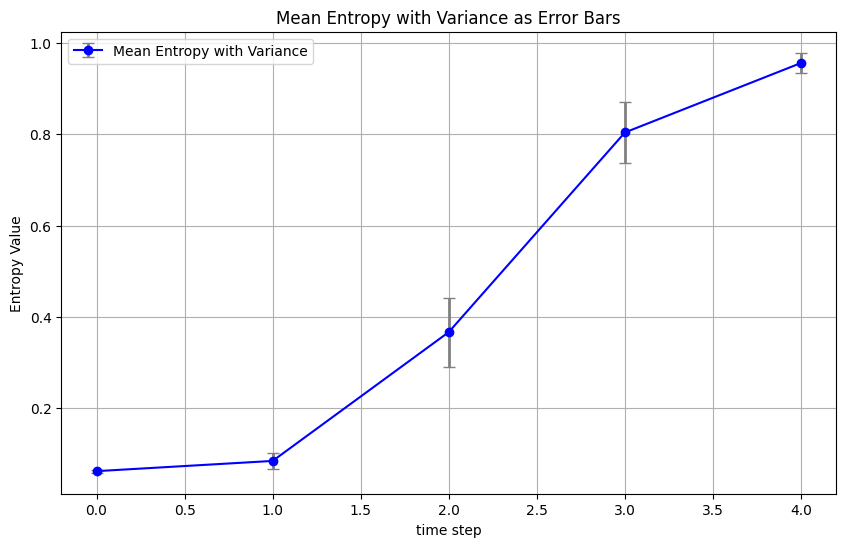

In [13]:
plt.figure(figsize=(10, 6))

plt.errorbar(range(args.steps), mean_entropy_arr, yerr=var_entropy_arr, fmt='-o', color='b', 
             ecolor='gray', elinewidth=2, capsize=4, label='Mean Entropy with Variance')

# 라벨, 제목, 범례 추가
plt.xlabel('time step')
plt.ylabel('Entropy Value')
plt.title('Mean Entropy with Variance as Error Bars')
plt.legend()
plt.grid()

# 그래프 출력
plt.show()

In [17]:
t = torch.tensor([1] * 3)
print(t.shape)

torch.Size([3])


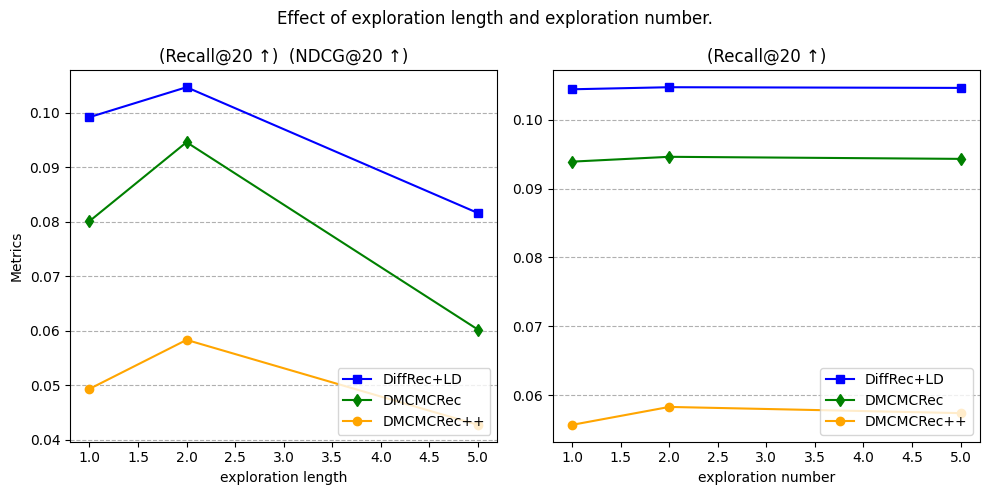

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the first graph (s)
s_values = [1, 2, 5]
recall_s = [0.0992, 0.1047, 0.0816]
ndcg_s = [0.0801, 0.0946, 0.0602]
mcmc_p1 = [0.0493, 0.0583, 0.0427]

# Data for the second graph (T)
t_values = [1, 2, 5]
recall_t = [0.1044, 0.1047, 0.1046]
ndcg_t = [0.0939, 0.0946, 0.0943]
mcmc_p2 = [0.0557, 0.0583, 0.0574]

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first graph (s)
axes[0].plot(s_values, recall_s, marker='s', label='DiffRec+LD', color='blue')
axes[0].plot(s_values, ndcg_s, marker='d', label='DMCMCRec', color='green')
axes[0].plot(s_values, mcmc_p1, marker='o', label='DMCMCRec++', color='orange')
axes[0].set_xlabel('exploration length')
axes[0].set_ylabel('Metrics')
axes[0].set_title('(Recall@20 ↑)  (NDCG@20 ↑)')
axes[0].legend(loc='lower right')
axes[0].grid(True, axis='y', linestyle='--')
axes[0].xticks([1,2,5])

# Plot the second graph (T)
axes[1].plot(t_values, recall_t, marker='s', label='DiffRec+LD', color='blue')
axes[1].plot(t_values, ndcg_t, marker='d', label='DMCMCRec', color='green')
axes[1].plot(t_values, mcmc_p2, marker='o', label='DMCMCRec++', color='orange')
axes[1].set_xlabel('exploration number')
axes[1].set_title('(Recall@20 ↑)')
axes[1].legend(loc='lower right')
axes[1].grid(True, axis='y', linestyle='--')
axes[1].xticks([1,2,5])

# Adjust the layout
fig.suptitle('Effect of exploration length and exploration number.')
plt.tight_layout()
plt.show()
